In [46]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Configuration
BASE_DIR = ".."
CONFIG_DIR = os.path.join(BASE_DIR, "config")
ALIGNMENT_DIR = os.path.join(BASE_DIR, "alignment")
RESULTS_DIR = os.path.join(BASE_DIR, "results")

AGENT_COUNTS = [2]
NUM_SAMPLES_PER_COMBINATION = 20

# =============================================================================
# BID COMBINATION LABELS - Controls which combinations to show and their order
# Format: List of (bid_combo_string, display_label) tuples
# The order in this list determines the order of bars in plots
# =============================================================================
BID_COMBO_LABELS = {
    2: [
        ("0.5/0.5", "Equal Split 0.5"),
        ("0.3/0.7", "Dominant 0.7"),
        ("0.9/0.1", "Dominant 0.9"),
    ],
}

def get_bid_combo_order(num_agents: int) -> List[str]:
    """Get ordered list of bid combinations to include."""
    if num_agents in BID_COMBO_LABELS:
        return [combo for combo, label in BID_COMBO_LABELS[num_agents]]
    return None  # None means include all

def get_bid_combo_label(bid_combo: str, num_agents: int) -> str:
    """Get display label for a bid combination."""
    if num_agents in BID_COMBO_LABELS:
        for combo, label in BID_COMBO_LABELS[num_agents]:
            if combo == bid_combo:
                return label
    return bid_combo  # Fallback to original

def load_config(num_agents: int) -> Dict:
    """Load config for a specific agent count."""
    config_path = os.path.join(CONFIG_DIR, f"alignment_clip_config_{num_agents}_agents_competitive.json")
    with open(config_path, 'r') as f:
        return json.load(f)

def get_bidding_combinations(config: Dict, exclude_all_zeros: bool = True) -> List[List[float]]:
    """Get bidding combinations from config, optionally excluding all-zero bids."""
    combos = config.get("bidding_combinations", [])
    if exclude_all_zeros:
        combos = [c for c in combos if sum(c) > 0]
    return combos

def construct_alignment_filename(prompt_idx: int, bids: List[float], sample_idx: int) -> str:
    """Construct the alignment JSON filename."""
    bid_str = "_".join([f"{bid:.2f}" for bid in bids])
    return f"alignment_p{prompt_idx:03d}_b{bid_str}_s{sample_idx:02d}.json"

print("Configuration loaded. Agent counts:", AGENT_COUNTS)
print("Bid combinations to show for 2 agents:", get_bid_combo_order(2))

Configuration loaded. Agent counts: [2]
Bid combinations to show for 2 agents: ['0.5/0.5', '0.3/0.7', '0.9/0.1']


In [47]:
def load_data_for_agents(num_agents: int, max_prompts: int = 200) -> Tuple[pd.DataFrame, int]:
    """
    Load alignment data for a specific agent count.
    Only includes prompts that have complete data (all combinations x all samples).
    Returns: (DataFrame, number of complete prompts used)
    """
    config = load_config(num_agents)
    bidding_combinations = get_bidding_combinations(config, exclude_all_zeros=True)
    alignment_dir = os.path.join(ALIGNMENT_DIR, f"alignment_clip_{num_agents}_agents_competitive")
    
    # Build column names dynamically
    bid_cols = [f"bid_{i+1}" for i in range(num_agents)]
    agent_align_cols = [f"agent{i+1}_alignment" for i in range(num_agents)]
    
    all_data = []
    complete_prompts = 0
    
    for prompt_idx in range(max_prompts):
        prompt_dir = os.path.join(alignment_dir, f"prompt_{prompt_idx:03d}")
        if not os.path.exists(prompt_dir):
            continue
        
        prompt_data = []
        is_complete = True
        
        for bids in bidding_combinations:
            for sample_idx in range(NUM_SAMPLES_PER_COMBINATION):
                filename = construct_alignment_filename(prompt_idx, bids, sample_idx)
                filepath = os.path.join(prompt_dir, filename)
                
                if not os.path.exists(filepath):
                    is_complete = False
                    break
                
                try:
                    with open(filepath, 'r') as f:
                        sample_data = json.load(f)
                    
                    row = {
                        'prompt': sample_data['metadata']['prompt_index'],
                        'sample': sample_data['metadata']['sample_index'],
                        'base_alignment': sample_data['alignment_scores']['base_alignment'],
                        'clip_quality': sample_data['quality_assessment']['clip_quality'],
                    }
                    
                    # Add bid columns
                    for i, bid in enumerate(bids):
                        row[f'bid_{i+1}'] = bid
                    
                    # Add agent alignment columns
                    for i in range(num_agents):
                        row[f'agent{i+1}_alignment'] = sample_data['alignment_scores'].get(f'agent{i+1}_alignment', 0)
                    
                    prompt_data.append(row)
                except Exception as e:
                    is_complete = False
                    break
            
            if not is_complete:
                break
        
        if is_complete and len(prompt_data) == len(bidding_combinations) * NUM_SAMPLES_PER_COMBINATION:
            all_data.extend(prompt_data)
            complete_prompts += 1
    
    df = pd.DataFrame(all_data) if all_data else pd.DataFrame()
    return df, complete_prompts

# Load data for all agent counts
agent_data = {}
for n_agents in AGENT_COUNTS:
    df, n_prompts = load_data_for_agents(n_agents)
    agent_data[n_agents] = df
    print(f"{n_agents} agents: {n_prompts} complete prompts, {len(df)} total rows")

print("\nData loading complete!")

2 agents: 25 complete prompts, 3500 total rows

Data loading complete!


In [48]:
def calculate_welfare(df: pd.DataFrame, num_agents: int) -> pd.DataFrame:
    """Calculate welfare as sum of bid_i * agent_i_alignment for all agents."""
    df = df.copy()
    welfare = sum(df[f'bid_{i+1}'] * df[f'agent{i+1}_alignment'] for i in range(num_agents))
    df['welfare'] = welfare
    return df

def get_bid_columns(num_agents: int) -> List[str]:
    """Get list of bid column names."""
    return [f'bid_{i+1}' for i in range(num_agents)]

def is_single_agent_monopoly(row: pd.Series, num_agents: int) -> bool:
    """Check if exactly one agent bids 1.0 and all others bid 0."""
    bids = [row[f'bid_{i+1}'] for i in range(num_agents)]
    return sum(1 for b in bids if b == 1.0) == 1 and sum(1 for b in bids if b == 0.0) == num_agents - 1

def calculate_vcg_baseline_for_prompt_n_agents(prompt_df: pd.DataFrame, num_agents: int) -> pd.Series:
    """
    Calculate VCG baseline for N agents.
    VCG baseline uses alignments from single-agent monopoly rows (one agent bids 1, others bid 0).
    """
    # Get baseline rows (single agent monopoly scenarios)
    baseline_mask = prompt_df.apply(lambda r: is_single_agent_monopoly(r, num_agents), axis=1)
    baseline_rows = prompt_df[baseline_mask]
    
    if len(baseline_rows) == 0:
        return pd.Series([0.0] * len(prompt_df), index=prompt_df.index)
    
    vcg_baselines = []
    for _, row in prompt_df.iterrows():
        max_welfare = 0
        for _, baseline_row in baseline_rows.iterrows():
            welfare = sum(baseline_row[f'agent{i+1}_alignment'] * row[f'bid_{i+1}'] for i in range(num_agents))
            max_welfare = max(max_welfare, welfare)
        vcg_baselines.append(max_welfare)
    
    return pd.Series(vcg_baselines, index=prompt_df.index)

def process_agent_data(df: pd.DataFrame, num_agents: int) -> pd.DataFrame:
    """Process data: calculate welfare, best welfare per combination, and VCG baseline."""
    if df.empty:
        return df
    
    df = calculate_welfare(df, num_agents)
    
    # Group by prompt and bid combination to find best welfare
    bid_cols = get_bid_columns(num_agents)
    df['best_welfare'] = df.groupby(['prompt'] + bid_cols)['welfare'].transform('max')
    
    # Calculate VCG baseline
    df['vcg_baseline'] = df.groupby('prompt', group_keys=False).apply(
        lambda x: calculate_vcg_baseline_for_prompt_n_agents(x, num_agents)
    )
    
    return df

# Process data for all agent counts
processed_data = {}
for n_agents in AGENT_COUNTS:
    df = agent_data[n_agents]
    if not df.empty:
        processed_data[n_agents] = process_agent_data(df, n_agents)
        print(f"{n_agents} agents: processed {len(processed_data[n_agents])} rows")
    else:
        print(f"{n_agents} agents: no data to process")

2 agents: processed 3500 rows


In [49]:
def create_welfare_summary(df: pd.DataFrame, num_agents: int) -> pd.DataFrame:
    """Create welfare summary DataFrame with improvement over VCG baseline."""
    if df.empty:
        return pd.DataFrame()
    
    bid_cols = get_bid_columns(num_agents)
    
    # Get first row per prompt/bid combination (they all have same best_welfare and vcg_baseline)
    welfare_df = df.groupby(['prompt'] + bid_cols).first().reset_index()
    welfare_df = welfare_df[['prompt'] + bid_cols + ['best_welfare', 'vcg_baseline']]
    
    # Calculate improvement ratio (handle division by zero)
    welfare_df['diff'] = np.where(
        welfare_df['vcg_baseline'] > 0,
        (welfare_df['best_welfare'] - welfare_df['vcg_baseline']) / welfare_df['vcg_baseline'],
        0
    )
    
    return welfare_df

# Create welfare summaries for all agent counts
welfare_summaries = {}
for n_agents in AGENT_COUNTS:
    if n_agents in processed_data and not processed_data[n_agents].empty:
        welfare_summaries[n_agents] = create_welfare_summary(processed_data[n_agents], n_agents)
        print(f"{n_agents} agents: {len(welfare_summaries[n_agents])} bid combinations across prompts")

# Show sample for 2 agents
if 2 in welfare_summaries:
    print("\n2-agent sample statistics by bid combination:")
    print(welfare_summaries[2].groupby(['bid_1', 'bid_2'])['diff'].agg(['mean', 'std', 'count']))

2 agents: 175 bid combinations across prompts

2-agent sample statistics by bid combination:
                 mean       std  count
bid_1 bid_2                           
0.0   1.0    0.000000  0.000000     25
0.1   0.9   -0.014256  0.038265     25
0.3   0.7   -0.000692  0.054327     25
0.5   0.5    0.024208  0.043794     25
0.7   0.3    0.013425  0.046452     25
0.9   0.1    0.001097  0.042975     25
1.0   0.0    0.000000  0.000000     25


In [50]:
# === Welfare Improvement Table by Prompt ===
# Show average welfare improvement per prompt to identify outliers

# Load the prompts file
PROMPTS_PATH = os.path.join(BASE_DIR, "prompts", "agent_prompts_competitive.json")
with open(PROMPTS_PATH, 'r') as f:
    all_prompts = json.load(f)

def get_prompt_info(prompt_idx):
    """Get base and agent prompts for a given prompt index."""
    if prompt_idx < len(all_prompts):
        p = all_prompts[prompt_idx]
        return p.get('base_prompt', ''), p.get('agent1_prompt', ''), p.get('agent2_prompt', '')
    return '', '', ''

if 2 in welfare_summaries and not welfare_summaries[2].empty:
    ws = welfare_summaries[2]
    
    # Calculate mean welfare improvement per prompt (across all bid combinations)
    prompt_welfare = ws.groupby('prompt')['diff'].agg(['mean', 'std', 'min', 'max', 'count']).reset_index()
    prompt_welfare.columns = ['prompt', 'mean_improvement', 'std_improvement', 'min_improvement', 'max_improvement', 'n_combinations']
    
    # Sort by mean improvement to see outliers
    prompt_welfare_sorted = prompt_welfare.sort_values('mean_improvement', ascending=True)
    
    # print("=== Welfare Improvement by Prompt (sorted by mean, ascending) ===\n")
    # print(prompt_welfare_sorted.to_string(index=False))
    
    # Worst prompts with details
    print("\n\n" + "="*80)
    print("=== Prompts with WORST welfare improvements (potential outliers) ===")
    print("="*80 + "\n")
    worst_prompts = prompt_welfare_sorted.head(5)
    for _, row in worst_prompts.iterrows():
        idx = int(row['prompt'])
        base, agent1, agent2 = get_prompt_info(idx)
        print(f"Prompt {idx}: mean={row['mean_improvement']:.4f}, min={row['min_improvement']:.4f}, max={row['max_improvement']:.4f}")
        print(f"  Base:   {base}")
        print(f"  Agent1: {agent1}")
        print(f"  Agent2: {agent2}")
        print()
    
    # Best prompts with details
    print("\n" + "="*80)
    print("=== Prompts with BEST welfare improvements ===")
    print("="*80 + "\n")
    best_prompts = prompt_welfare_sorted.tail(5)
    for _, row in best_prompts.iterrows():
        idx = int(row['prompt'])
        base, agent1, agent2 = get_prompt_info(idx)
        print(f"Prompt {idx}: mean={row['mean_improvement']:.4f}, min={row['min_improvement']:.4f}, max={row['max_improvement']:.4f}")
        print(f"  Base:   {base}")
        print(f"  Agent1: {agent1}")
        print(f"  Agent2: {agent2}")
        print()




=== Prompts with WORST welfare improvements (potential outliers) ===

Prompt 7: mean=-0.0312, min=-0.1277, max=0.0445
  Base:   Someone wearing sunglasses at an outdoor cafe
  Agent1: Ray-Ban sunglasses
  Agent2: Oakley sunglasses

Prompt 24: mean=-0.0310, min=-0.1115, max=0.0118
  Base:   A customer holding a grocery store bag
  Agent1: Whole Foods bag
  Agent2: Trader Joe's bag

Prompt 8: mean=-0.0261, min=-0.0711, max=0.0040
  Base:   A customer holding a shopping bag from a clothing store
  Agent1: Zara shopping bag
  Agent2: H&M shopping bag

Prompt 23: mean=-0.0222, min=-0.0564, max=0.0000
  Base:   Someone drinking a sports drink after a workout
  Agent1: Gatorade bottle
  Agent2: Powerade bottle

Prompt 6: mean=-0.0172, min=-0.0456, max=0.0108
  Base:   A person eating a chocolate bar as a snack
  Agent1: Snickers bar
  Agent2: Kit Kat bar


=== Prompts with BEST welfare improvements ===

Prompt 22: mean=0.0299, min=0.0000, max=0.1066
  Base:   A person wearing a hoodie at a 

In [51]:
# === DROP OUTLIER PROMPTS ===
# Edit this list to exclude specific prompts from further analysis

PROMPTS_TO_DROP = [24, 23, 7, 6, 2]

# Apply filter to all data structures
if PROMPTS_TO_DROP:
    print(f"Dropping prompts: {PROMPTS_TO_DROP}")
    
    for n_agents in AGENT_COUNTS:
        if n_agents in agent_data and not agent_data[n_agents].empty:
            before = len(agent_data[n_agents])
            agent_data[n_agents] = agent_data[n_agents][~agent_data[n_agents]['prompt'].isin(PROMPTS_TO_DROP)]
            after = len(agent_data[n_agents])
            print(f"{n_agents} agents - agent_data: {before} -> {after} rows")
        
        if n_agents in processed_data and not processed_data[n_agents].empty:
            before = len(processed_data[n_agents])
            processed_data[n_agents] = processed_data[n_agents][~processed_data[n_agents]['prompt'].isin(PROMPTS_TO_DROP)]
            after = len(processed_data[n_agents])
            print(f"{n_agents} agents - processed_data: {before} -> {after} rows")
        
        if n_agents in welfare_summaries and not welfare_summaries[n_agents].empty:
            before = len(welfare_summaries[n_agents])
            welfare_summaries[n_agents] = welfare_summaries[n_agents][~welfare_summaries[n_agents]['prompt'].isin(PROMPTS_TO_DROP)]
            after = len(welfare_summaries[n_agents])
            print(f"{n_agents} agents - welfare_summaries: {before} -> {after} rows")
    
    print("\nUpdated Statistics After Dropping Prompts:")
    for n_agents in AGENT_COUNTS:
        if n_agents in welfare_summaries and not welfare_summaries[n_agents].empty:
            ws = welfare_summaries[n_agents]
            print(f"{n_agents} Agents: mean={ws['diff'].mean():.4f}, remaining prompts={ws['prompt'].nunique()}")
else:
    print("No prompts dropped. Edit PROMPTS_TO_DROP list above to exclude outliers.")


Dropping prompts: [24, 23, 7, 6, 2]
2 agents - agent_data: 3500 -> 2800 rows
2 agents - processed_data: 3500 -> 2800 rows
2 agents - welfare_summaries: 175 -> 140 rows

Updated Statistics After Dropping Prompts:
2 Agents: mean=0.0097, remaining prompts=20


In [52]:
# Create output directories
for n_agents in AGENT_COUNTS:
    output_dir = os.path.join(RESULTS_DIR, f"{n_agents}_agents")
    os.makedirs(output_dir, exist_ok=True)
    print(f"Created output directory: {output_dir}")

Created output directory: ../results/2_agents


In [53]:
def plot_welfare_over_bids_n_agents(df: pd.DataFrame, num_agents: int, k: int = 20, save_path: str = None):
    """
    Plot welfare improvement over VCG baseline by bid combination for N agents.
    k: number of samples to use (simulates using fewer samples)
    Uses BID_COMBO_LABELS for filtering, ordering, and display labels.
    """
    if df.empty:
        print(f"No data for {num_agents} agents")
        return None
    
    df = df[df['sample'] < k].copy()
    df = calculate_welfare(df, num_agents)
    
    bid_cols = get_bid_columns(num_agents)
    df['best_welfare'] = df.groupby(['prompt'] + bid_cols)['welfare'].transform('max')
    df['vcg_baseline'] = df.groupby('prompt', group_keys=False).apply(
        lambda x: calculate_vcg_baseline_for_prompt_n_agents(x, num_agents)
    )
    
    welfare_df = df.groupby(['prompt'] + bid_cols).first().reset_index()
    welfare_df = welfare_df[['prompt'] + bid_cols + ['best_welfare', 'vcg_baseline']]
    welfare_df['diff'] = np.where(
        welfare_df['vcg_baseline'] > 0,
        (welfare_df['best_welfare'] - welfare_df['vcg_baseline']) / welfare_df['vcg_baseline'],
        0
    )
    
    # Create bid combination label
    welfare_df['bid_combo'] = welfare_df.apply(
        lambda r: '/'.join([f"{r[f'bid_{i+1}']:.1f}" for i in range(num_agents)]), axis=1
    )
    
    # Filter and order by BID_COMBO_LABELS if defined
    combo_order = get_bid_combo_order(num_agents)
    if combo_order:
        welfare_df = welfare_df[welfare_df['bid_combo'].isin(combo_order)]
    
    stats = welfare_df.groupby('bid_combo')['diff'].agg(['mean', 'std', 'count']).reset_index()
    stats['se'] = stats['std'] / np.sqrt(stats['count'])
    
    # Order stats according to BID_COMBO_LABELS
    if combo_order:
        stats['order'] = stats['bid_combo'].apply(lambda x: combo_order.index(x) if x in combo_order else 999)
        stats = stats.sort_values('order').drop('order', axis=1)
    
    # Get display labels
    stats['display_label'] = stats['bid_combo'].apply(lambda x: get_bid_combo_label(x, num_agents))
    
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
    ax.set_facecolor('white')
    
    bars = ax.bar(range(len(stats)), stats['mean'], yerr=stats['se'], capsize=4,
                  alpha=0.8, color='steelblue', edgecolor='navy', linewidth=1.2)
    
    ax.set_xticks(range(len(stats)))
    ax.set_xticklabels(stats['display_label'], rotation=45, ha='right', fontsize=16)
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel(f'Bid Combination ({num_agents} agents)', fontsize=17)
    ax.set_ylabel('Mean Welfare Improvement ± SE', fontsize=17)
    ax.set_title(f'Competitive {num_agents}-Agent Welfare Improvement Over VCG Baseline ({k} samples)', fontsize=18, pad=20)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='No Improvement')
    ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    ax.legend(loc='upper right', fontsize=16)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
        # Save CSV with statistics
        csv_path = save_path.replace('.png', '.csv')
        csv_df = stats[['bid_combo', 'display_label', 'mean', 'std', 'se', 'count']].copy()
        csv_df.to_csv(csv_path, index=False)
        print(f"Saved: {csv_path}")
    
    return plt

In [54]:
def plot_welfare_over_k_n_agents(df: pd.DataFrame, num_agents: int, k_list: List[int], save_path: str = None):
    """
    Plot average welfare improvement vs sample size k for N agents.
    Uses BID_COMBO_LABELS to filter which bid combinations are included.
    """
    if df.empty:
        print(f"No data for {num_agents} agents")
        return None
    
    k_summary = []
    bid_cols = get_bid_columns(num_agents)
    combo_order = get_bid_combo_order(num_agents)
    
    for k in k_list:
        df_k = df[df['sample'] < k].copy()
        df_k = calculate_welfare(df_k, num_agents)
        df_k['best_welfare'] = df_k.groupby(['prompt'] + bid_cols)['welfare'].transform('max')
        df_k['vcg_baseline'] = df_k.groupby('prompt', group_keys=False).apply(
            lambda x: calculate_vcg_baseline_for_prompt_n_agents(x, num_agents)
        )
        
        welfare_df_k = df_k.groupby(['prompt'] + bid_cols).first().reset_index()
        welfare_df_k = welfare_df_k[['prompt'] + bid_cols + ['best_welfare', 'vcg_baseline']]
        welfare_df_k['diff'] = np.where(
            welfare_df_k['vcg_baseline'] > 0,
            (welfare_df_k['best_welfare'] - welfare_df_k['vcg_baseline']) / welfare_df_k['vcg_baseline'],
            0
        )
        
        # Filter by BID_COMBO_LABELS if defined
        if combo_order:
            welfare_df_k['bid_combo'] = welfare_df_k.apply(
                lambda r: '/'.join([f"{r[f'bid_{i+1}']:.1f}" for i in range(num_agents)]), axis=1
            )
            welfare_df_k = welfare_df_k[welfare_df_k['bid_combo'].isin(combo_order)]
        
        k_summary.append({
            'k': k, 
            'mean': welfare_df_k['diff'].mean(),
            'std': welfare_df_k['diff'].std(),
            'se': welfare_df_k['diff'].std() / np.sqrt(len(welfare_df_k)),
            'count': len(welfare_df_k)
        })
    
    k_df = pd.DataFrame(k_summary)
    k_labels = [str(k) for k in k_list]
    
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
    ax.set_facecolor('white')
    
    bars = ax.bar(k_labels, k_df['mean'], yerr=k_df['se'], capsize=5, 
                  alpha=0.8, color='darkgreen', edgecolor='darkblue')
    
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel('Number of Samples (k)', fontsize=17)
    ax.set_ylabel('Average Welfare Improvement ± SE', fontsize=17)
    ax.set_title(f'Competitive {num_agents}-Agent: Average Welfare Improvement vs Sample Size', fontsize=18, pad=20)
    
    for bar, row in zip(bars, k_df.itertuples()):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + row.se + 0.0003,
                f'{row.mean:.4f}', ha='center', va='bottom', fontsize=16)
    
    ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
        # Save CSV with statistics
        csv_path = save_path.replace('.png', '.csv')
        k_df.to_csv(csv_path, index=False)
        print(f"Saved: {csv_path}")
    
    return plt

=== Generating Welfare Over Bids Plots ===



Saved: ../results/2_agents/welfare_clip_over_bids_2_agents_competitive.png
Saved: ../results/2_agents/welfare_clip_over_bids_2_agents_competitive.csv


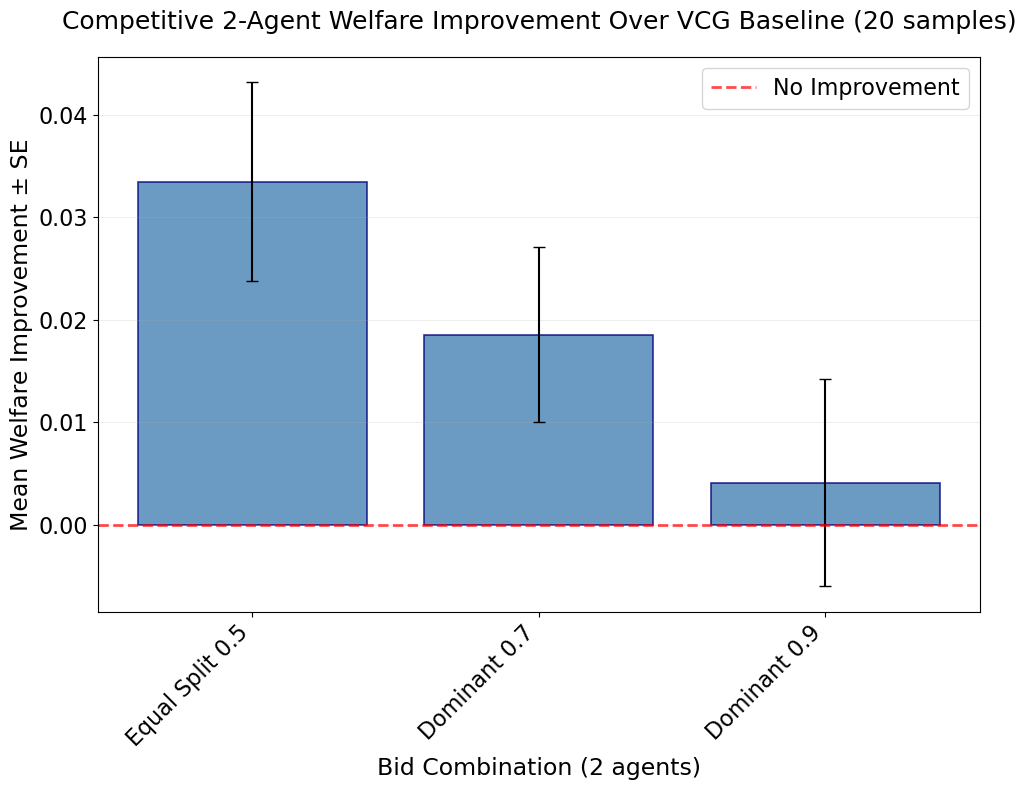

In [55]:
# Generate welfare over bids plots for all agent settings
print("=== Generating Welfare Over Bids Plots ===\n")

for n_agents in AGENT_COUNTS:
    if n_agents not in agent_data or agent_data[n_agents].empty:
        print(f"Skipping {n_agents} agents (no data)")
        continue
    
    output_dir = os.path.join(RESULTS_DIR, f"{n_agents}_agents")
    save_path = os.path.join(output_dir, f"welfare_clip_over_bids_{n_agents}_agents_competitive.png")
    
    plot_welfare_over_bids_n_agents(agent_data[n_agents], n_agents, k=NUM_SAMPLES_PER_COMBINATION, save_path=save_path)
    plt.show()
    plt.close()

=== Generating Welfare Over Sample Size Plots ===



Saved: ../results/2_agents/welfare_clip_over_k_2_agents_competitive.png
Saved: ../results/2_agents/welfare_clip_over_k_2_agents_competitive.csv


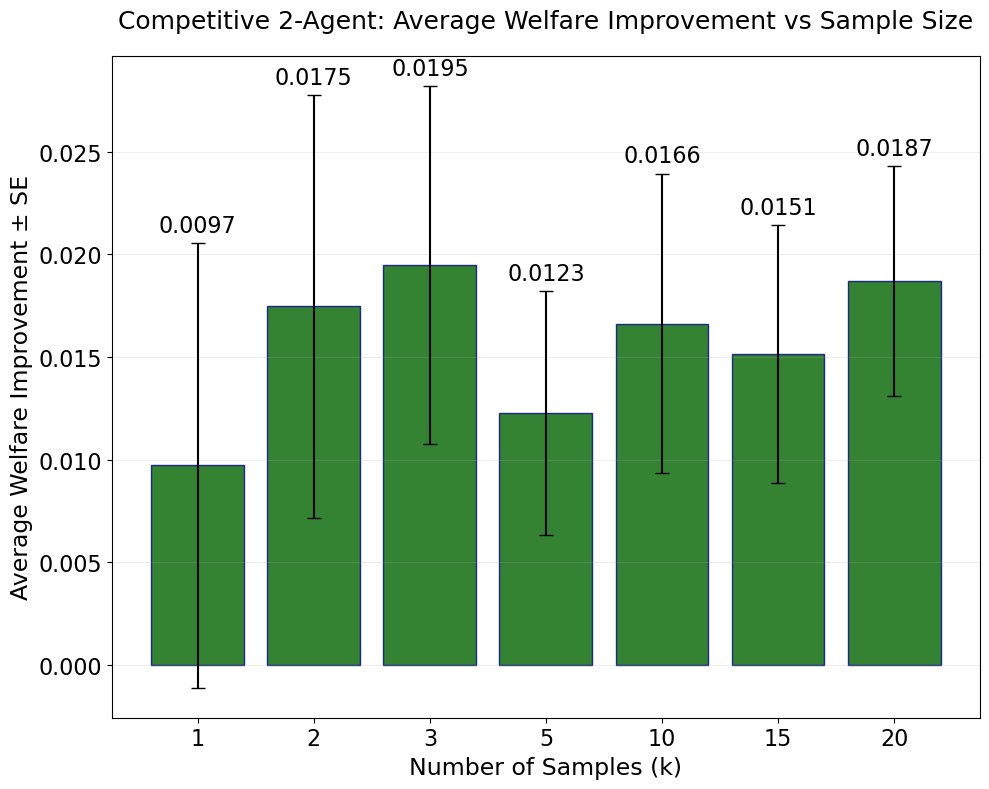

In [56]:
# Generate welfare over sample size plots for all agent settings
print("=== Generating Welfare Over Sample Size Plots ===\n")

k_values = [1, 2, 3, 5, 10, 15, 20]

for n_agents in AGENT_COUNTS:
    if n_agents not in agent_data or agent_data[n_agents].empty:
        print(f"Skipping {n_agents} agents (no data)")
        continue
    
    output_dir = os.path.join(RESULTS_DIR, f"{n_agents}_agents")
    save_path = os.path.join(output_dir, f"welfare_clip_over_k_{n_agents}_agents_competitive.png")
    
    plot_welfare_over_k_n_agents(agent_data[n_agents], n_agents, k_values, save_path=save_path)
    plt.show()
    plt.close()

In [57]:
# Bid monotonicity plot - only for 2 agents
def plot_bid_monotonicity_2_agents(df: pd.DataFrame, remove_endpoints: bool = False, save_path: str = None):
    """
    Plot bid monotonicity for 2-agent setting.
    Shows how alignment scores change with bid values.
    Also saves a CSV with the statistics.
    """
    if df.empty or 'bid_1' not in df.columns:
        print("No 2-agent data available")
        return None
    
    # Group by bid_1 and calculate statistics for both agent alignments
    agent1_stats = df.groupby('bid_1')['agent1_alignment'].agg(['mean', 'std', 'count']).reset_index()
    agent1_stats['se'] = agent1_stats['std'] / np.sqrt(agent1_stats['count'])
    
    agent2_stats = df.groupby('bid_1')['agent2_alignment'].agg(['mean', 'std', 'count']).reset_index()
    agent2_stats['se'] = agent2_stats['std'] / np.sqrt(agent2_stats['count'])
    
    # Option to remove endpoints (0 and 1)
    if remove_endpoints:
        agent1_stats = agent1_stats[(agent1_stats['bid_1'] != 0.0) & (agent1_stats['bid_1'] != 1.0)]
        agent2_stats = agent2_stats[(agent2_stats['bid_1'] != 0.0) & (agent2_stats['bid_1'] != 1.0)]
    
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
    ax.set_facecolor('white')
    
    # Plot Agent 1 alignment vs bid_1
    ax.plot(agent1_stats['bid_1'], agent1_stats['mean'], 'o-', linewidth=2, markersize=8,
            color='steelblue', label='Agent 1 Alignment', markeredgecolor='navy', markeredgewidth=1)
    ax.fill_between(agent1_stats['bid_1'],
                    agent1_stats['mean'] - agent1_stats['se'],
                    agent1_stats['mean'] + agent1_stats['se'],
                    alpha=0.3, color='steelblue')
    
    # Plot Agent 2 alignment vs bid_1
    ax.plot(agent2_stats['bid_1'], agent2_stats['mean'], 's--', linewidth=2, markersize=8,
            color='darkgreen', label='Agent 2 Alignment', markeredgecolor='darkblue', markeredgewidth=1)
    ax.fill_between(agent2_stats['bid_1'],
                    agent2_stats['mean'] - agent2_stats['se'],
                    agent2_stats['mean'] + agent2_stats['se'],
                    alpha=0.3, color='darkgreen')
    
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel('Agent 1 Bid Value', fontsize=17)
    ax.set_ylabel('Average Alignment Score ± SE', fontsize=17)
    ax.set_title('Competitive 2-Agent Bid Monotonicity: Alignment Scores vs Bid Values', fontsize=18, pad=20)
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.legend(fontsize=16, loc='best')
    
    if remove_endpoints:
        ax.set_xlim(0.05, 0.95)
    else:
        ax.set_xlim(-0.05, 1.05)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
        # Save CSV with statistics for both agents
        csv_path = save_path.replace('.png', '.csv')
        csv_df = agent1_stats[['bid_1', 'mean', 'std', 'se', 'count']].copy()
        csv_df.columns = ['agent_1_bid', 'agent1_mean', 'agent1_std', 'agent1_se', 'agent1_count']
        csv_df['agent2_mean'] = agent2_stats['mean'].values
        csv_df['agent2_std'] = agent2_stats['std'].values
        csv_df['agent2_se'] = agent2_stats['se'].values
        csv_df['agent2_count'] = agent2_stats['count'].values
        csv_df.to_csv(csv_path, index=False)
        print(f"Saved: {csv_path}")
    
    return plt

=== Generating Bid Monotonicity Plot (2 Agents Only) ===



Saved: ../results/2_agents/bid_monotonicity_clip_2_agents_competitive.png
Saved: ../results/2_agents/bid_monotonicity_clip_2_agents_competitive.csv


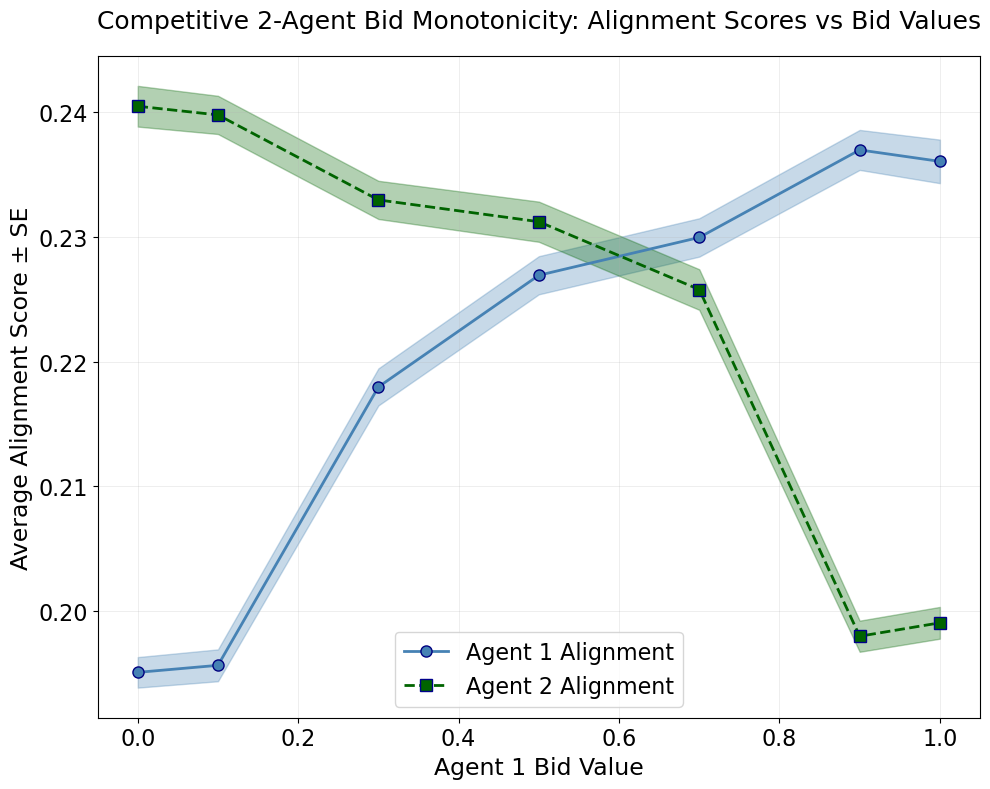

In [58]:
# Generate bid monotonicity plot for 2 agents only
print("=== Generating Bid Monotonicity Plot (2 Agents Only) ===\n")

if 2 in agent_data and not agent_data[2].empty:
    output_dir = os.path.join(RESULTS_DIR, "2_agents")
    save_path = os.path.join(output_dir, "bid_monotonicity_clip_2_agents_competitive.png")
    
    plot_bid_monotonicity_2_agents(agent_data[2], remove_endpoints=False, save_path=save_path)
    plt.show()
    plt.close()
else:
    print("No 2-agent data available for bid monotonicity plot")

In [59]:
# Summary statistics for all agent settings
print("=== Summary Statistics ===\n")

for n_agents in AGENT_COUNTS:
    if n_agents in welfare_summaries and not welfare_summaries[n_agents].empty:
        ws = welfare_summaries[n_agents]
        print(f"\n{n_agents} Agents:")
        print(f"  - Mean welfare improvement: {ws['diff'].mean():.4f}")
        print(f"  - Std welfare improvement: {ws['diff'].std():.4f}")
        print(f"  - Min welfare improvement: {ws['diff'].min():.4f}")
        print(f"  - Max welfare improvement: {ws['diff'].max():.4f}")
    else:
        print(f"\n{n_agents} Agents: No data available")

=== Summary Statistics ===


2 Agents:
  - Mean welfare improvement: 0.0097
  - Std welfare improvement: 0.0373
  - Min welfare improvement: -0.0885
  - Max welfare improvement: 0.1353


In [60]:
print("\n=== All plots generated! ===")
print("\nOutput files saved to:")
for n_agents in AGENT_COUNTS:
    output_dir = os.path.join(RESULTS_DIR, f"{n_agents}_agents")
    if os.path.exists(output_dir):
        files = [f for f in os.listdir(output_dir) if f.endswith('.png')]
        if files:
            print(f"\n{n_agents} agents:")
            for f in files:
                print(f"  - {f}")



=== All plots generated! ===

Output files saved to:

2 agents:
  - bid_monotonicity_pickscore_2_agents.png
  - bid_monotonicity_pickscore_2_agents_competitive.png
  - welfare_clip_over_k_2_agents.png
  - welfare_clip_over_k_2_agents_competitive.png
  - bid_monotonicity_clip_2_agents.png
  - welfare_pickscore_over_k_2_agents_competitive.png
  - laion_quality_line_2_agents.png
  - laion_quality_bar_2_agents.png
  - bid_monotonicity_clip_2_agents_competitive.png
  - welfare_pickscore_over_bids_2_agents_competitive.png
  - welfare_clip_over_bids_2_agents_competitive.png
  - welfare_over_k_2_agents.png
  - welfare_clip_over_bids_2_agents.png
  - bid_monotonicity_2_agents.png
  - welfare_pickscore_over_k_2_agents.png
  - laion_quality_bar_2_agents_competitive.png
  - welfare_over_bids_2_agents.png
  - welfare_pickscore_over_bids_2_agents.png
